<font size="10">Model Identification with Neural Networks</font>

<font size="4">TBD.</font>

List all the saved models here for the reader...

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 4.5 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf. The general PINN framework here is adapted from the PINN in the repository [janblechschmidt/PDEsbyNNS](https://github.com/janblechschmidt/PDEsByNNs) from GitHub user [Jan Blechschmidt](https://github.com/janblechschmidt).</font>

In [ ]:
# Saved models info for later:
# 1. diff_N_d=100 only discovers diffusion coefficient. loss = 4.95294771e-05    cxx = -1.03864372e-01
# 2. diff_N_d=500 only discovers diffusion coefficient. loss = 1.92380521e-05    cxx = -1.00266308e-01
# 3. diff_N_d=1000 only discovers diffusion coefficient. loss = 8.22741276e-06    cxx = -1.03692450e-01
# 4. diff_advection discovers diffusion coefficient and advection coefficient. 
#           loss = 1.57217273e-05    cxx = -1.02045313e-01  cx = -4.57594991e-02
# 5. diff_linear discovers diffusion coefficient and linear term coefficient.
#           loss = 8.08515324e-05    cxx = -1.16206687e-02  cx = 0.00000000e+00  c1 = 9.00528610e-01

In [9]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# Define exact solution
def fun_u(t,x):
    return tf.exp(-0.1*t*pi**2)*tf.cos(pi*x) #6*(x+1)*( (x+1)**3 - 24*t )/( (x+1)**3 + 12*t )**2

In [10]:
# Set number of data points
N_r = 10000
N_d = 500

# Set boundary
tmin = 0.
tmax = 1.0
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
#tf.random.set_seed(0)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Draw uniformly sampled sample points
t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
X_d = tf.concat([t_d, x_d], axis=1)

# Sampled data inside domain
u_data = fun_u(t_d,x_d)

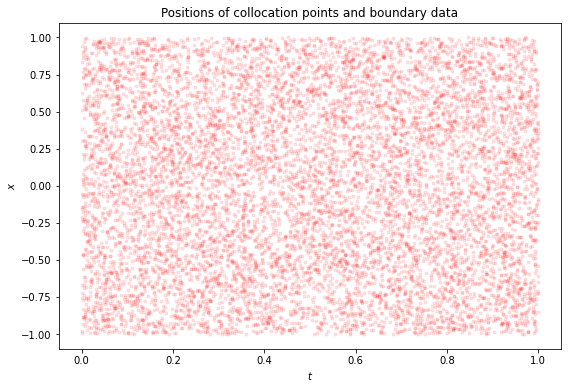

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [102]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    
    # Model coefficients
    model.ct = tf.Variable(1.0, trainable = False)
    model.cxx = tf.Variable(0.0, trainable = True) # If 'True' then discovery includes u_xx term (diffusion coefficient)
    model.cx = tf.Variable(0.0, trainable = False) # If 'True' then discovery includes u_x term
    model.c1 = tf.Variable(0.0, trainable = True) # If 'True' then discovery includes u term

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('selu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [103]:
def compute_loss(model, X_r, X_d, u_data):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x & u_xx within the GradientTape
        # since we need third derivatives
        u_x = tape.gradient(u, x)
        #u_xx = tape.gradient(u_x, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    
    del tape
    
    # Get model coefficients
    ct = model.ct
    cxx = model.cxx
    cx = model.cx
    c1 = model.c1
    
    # Model discovery loss term
    loss = tf.reduce_mean(tf.square( ct*u_t + cxx*u_xx + cx*u_x + c1*u ))
    
    # Data loss term
    t_d, x_d = X_d[:, 0:1], X_d[:,1:2]
    u_d = model(tf.stack([t_d[:,0], x_d[:,0]], axis=1))
    loss += tf.reduce_mean(tf.square(u_d - u_data))
    
    # Coefficient regularization
    #loss += 0.01*tf.abs(cxx)
    
    return loss

In [104]:
def get_grad(model, X_r, X_d, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_d, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [147]:
# Initialize model aka tilde u
model = init_model()

# Learning rate
lr = 1e-3

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [148]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_d, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 1000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}    cxx = {:10.8e}  cx = {:10.8e}  c1 = {:10.8e}'.format(i,loss,model.cxx.numpy(),model.cx.numpy(),model.c1.numpy()))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.53105772e-01    cxx = -9.99995391e-04  cx = 0.00000000e+00  c1 = 9.99913085e-04
It 00050: loss = 6.38404414e-02    cxx = -3.11981533e-02  cx = 0.00000000e+00  c1 = 4.99870582e-03
It 00100: loss = 2.06800699e-02    cxx = -3.81775275e-02  cx = 0.00000000e+00  c1 = 6.45787343e-02
It 00150: loss = 1.36376591e-02    cxx = -4.32250835e-02  cx = 0.00000000e+00  c1 = 1.19412154e-01
It 00200: loss = 1.21025275e-02    cxx = -4.52782698e-02  cx = 0.00000000e+00  c1 = 1.60959601e-01
It 00250: loss = 1.01793110e-02    cxx = -3.81013490e-02  cx = 0.00000000e+00  c1 = 1.94155291e-01
It 00300: loss = 8.53646547e-03    cxx = -3.69574055e-02  cx = 0.00000000e+00  c1 = 2.25546837e-01
It 00350: loss = 7.39617134e-03    cxx = -3.57651226e-02  cx = 0.00000000e+00  c1 = 2.55073041e-01
It 00400: loss = 7.05616083e-03    cxx = -3.33417840e-02  cx = 0.00000000e+00  c1 = 2.83271492e-01
It 00450: loss = 7.08852708e-03    cxx = -3.21095660e-02  cx = 0.00000000e+00  c1 = 3.11540961e-01
It 00500: 

In [149]:
# Checking that the linear and diffusive coefficients 
#     combine to produce the correct model based on the training data

check = (-pi**2*model.cxx + model.c1)
print(check.numpy()/(0.1*pi.numpy()**2)) # Exact value is 1 for a correct model

0.8337128470934261


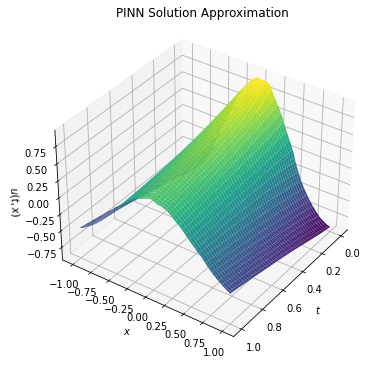

In [150]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
utrue = fun_u(tf.cast(T,DTYPE),tf.cast(X,DTYPE))
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('PINN Solution Approximation');

In [143]:
# Save network config
# !mkdir -p discovered_diffusion_models
#model.save('discovered_diffusion_models/diff_linear')

INFO:tensorflow:Assets written to: discovered_diffusion_models/diff_linear/assets
